In [1]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#from torchvision.models.detection import (
#    fasterrcnn_resnet50_fpn, 
#    FasterRCNN_ResNet50_FPN_Weights
#    )
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
from torchvision.transforms import functional as F

In [2]:
def load_model(checkpoint_path, num_classes=4):
    # 1. Инициализация модели с предобученными весами backbone
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn_v2(weights=weights)
    
    # 2. Замена box_predictor для своего числа классов
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # 3. Загрузка checkpoint
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    # 4. Извлекаем только веса модели (игнорируем optimizer и epoch)
    if 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    
    # 5. Аккуратная загрузка весов
    model.load_state_dict(state_dict, strict=False)  # strict=False пропустит отсутствующие ключи
    
    # 6. Перевод в режим оценки
    model.eval()
    
    return model

In [18]:
model = load_model(
    #checkpoint_path='/home/lastinm/PROJECTS/credit_cards_detection/train/Faster R-CNN/exp/summary/09-04-2025-06-15-03/best_model.pth',
    #checkpoint_path='/home/lastinm/PROJECTS/credit_cards_detection/train/Faster R-CNN/exp/summary/01-05-2025-12-59-16/best_model.pth',
    checkpoint_path='/home/lastinm/PROJECTS/credit_cards_detection/train/Faster R-CNN/exp/summary/01-05-2025-17-50-10/best_model.pth',
    num_classes=4  # Укажите реальное число ваших классов (3 класса + фон)
    )

In [4]:
def detect_objects(model, image_path, confidence_threshold=0.7):
    """
    Детекция объектов на изображении с помощью загруженной модели
    Args:
        model: Загруженная модель Faster R-CNN
        image_path: Путь к изображению
        confidence_threshold: Порог уверенности для отображения (0.0-1.0)
    Returns:
        Словарь с результатами детекции
    """
    # 1. Загрузка и преобразование изображения
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV -> RGB
    image_tensor = F.to_tensor(image)  # Конвертация в тензор [0-1]

    # 2. Добавление batch dimension и перемещение на устройство (GPU/CPU)
    image_tensor = image_tensor.unsqueeze(0).to(next(model.parameters()).device)
    
    # 3. Запуск модели (без вычисления градиентов)
    with torch.no_grad():
        predictions = model(image_tensor)
    
    # 4. Фильтрация результатов по порогу уверенности
    pred_boxes = predictions[0]['boxes'].cpu().numpy()
    pred_scores = predictions[0]['scores'].cpu().numpy()
    pred_classes = predictions[0]['labels'].cpu().numpy()
    
    keep = pred_scores >= confidence_threshold
    results = {
        'boxes': pred_boxes[keep],
        'scores': pred_scores[keep],
        'classes': pred_classes[keep]
    }
    
    return results

In [ ]:
def visualize_results_matplotlib(image_path, results, class_names):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    
    colors = ['yellow', 'green', 'blue', 'purple', 'red']
    
    for box, score, cls in zip(results['boxes'], results['scores'], results['classes']):
        x1, y1, x2, y2 = map(int, box)
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2, edgecolor=colors[cls % len(colors)], facecolor='none'
        )
        ax.add_patch(rect)
        
        plt.text(
            x1, y1-10, f"{class_names[cls]}: {score:.2f}",
            color=colors[cls % len(colors)], fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8)
        )
    
    plt.axis('off')
    plt.show()

In [8]:
image_path1 = '/home/lastinm/PROJECTS/credit_cards_detection/dataset/coco/test/1742460932138_resized_jpg.rf.0ee03bf49164c59d1ff4b929d05132cf.jpg'
image_path2 = '/home/lastinm/PROJECTS/credit_cards_detection/dataset/coco/test/1742460932095_resized_jpg.rf.8db93580eb26ebfc3f87db415cf4f1df.jpg'

In [11]:
def process_image(image_path):
    # 1. Детекция на изображении
    results = detect_objects(
        model=model,
        image_path=image_path,
        confidence_threshold=0.5  # Можно регулировать
        )
        
    # 2. Визуализация
    class_names = ["Background", "Cardholder", "CardNumber", "DateExpired"]  # Пример
    visualize_results_matplotlib(image_path, results, class_names)
        
    # 3. Вывод результатов в консоль
    print(f"Найдено объектов: {len(results['boxes'])}")
    for i, (box, score, cls) in enumerate(zip(results['boxes'], results['scores'], results['classes'])):
        print(f"Объект {i+1}: {class_names[cls]} (уверенность: {score:.2f})")
        print(f"Координаты: x1={box[0]:.1f}, y1={box[1]:.1f}, x2={box[2]:.1f}, y2={box[3]:.1f}")

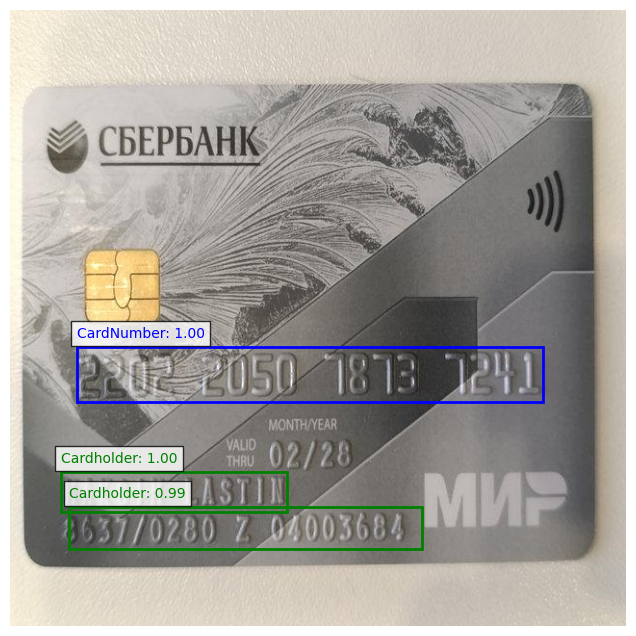

Найдено объектов: 3
Объект 1: Cardholder (уверенность: 1.00)
Координаты: x1=52.8, y1=480.6, x2=287.5, y2=521.8
Объект 2: CardNumber (уверенность: 1.00)
Координаты: x1=69.4, y1=350.9, x2=553.6, y2=407.2
Объект 3: Cardholder (уверенность: 0.99)
Координаты: x1=61.9, y1=516.7, x2=428.1, y2=559.6


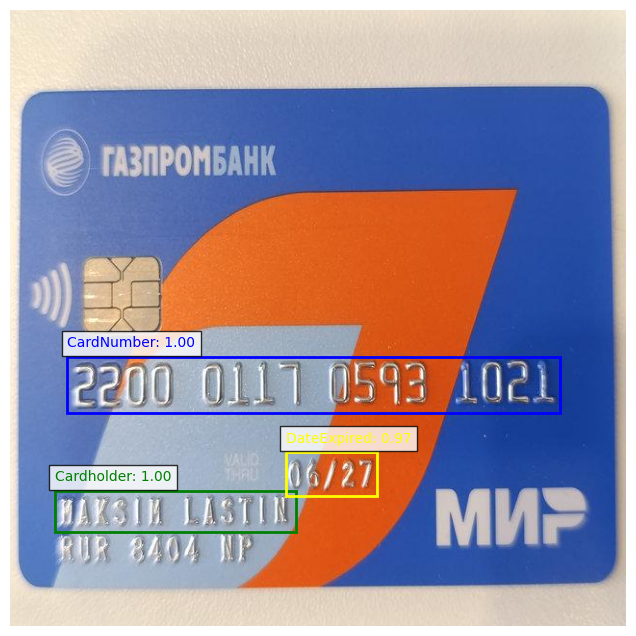

Найдено объектов: 3
Объект 1: Cardholder (уверенность: 1.00)
Координаты: x1=46.8, y1=499.9, x2=297.9, y2=542.2
Объект 2: CardNumber (уверенность: 1.00)
Координаты: x1=60.0, y1=360.2, x2=571.4, y2=418.5
Объект 3: DateExpired (уверенность: 0.97)
Координаты: x1=286.9, y1=459.5, x2=381.9, y2=504.9


In [19]:
process_image(image_path1)
process_image(image_path2)